# CS 133 PROJECT: MACHINE LEARNING MODEL
--------
### Team: Jonathan Manzano & Henry Pham  
Dataset: Autism in children  

[link to Proj Description](https://sjsu.instructure.com/courses/1580083/files/76444276?module_item_id=15357781)

Notes: 
1. Problem type: 
    - Classification

2. Testing Models:
    - Random Forest Classifier
    - Logistic Regression
    - Stochastic Gradient Descent
    - Support Vector Classifier

3. Conclusions:
    - Confusion Matrix
    - Best Testing Metric


In [37]:
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    StratifiedShuffleSplit,
    train_test_split,
    GridSearchCV,
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# if i knew what all of these were doing i would tell you

In [19]:
#read the data
def get_data():
    data="https://raw.githubusercontent.com/csbfx/cs133/main/autism_child.csv"
    df = pd.read_csv(data, sep=',', na_values = '?')
    return df

df = get_data()
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,country_of_res,used_app_before,total_score,age_desc,relation,ASD
0,1,1,0,0,1,1,0,1,0,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,...,m,NaN,no,no,Jordan,yes,5,4-11 years,NaN,NO
3,0,1,0,0,1,1,0,0,0,1,...,f,NaN,yes,no,Jordan,no,4,4-11 years,NaN,NO
4,1,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


In [7]:
# data preprocessing using StandardScaler only

# Handling Missing Values
df['age'].fillna(df['age'].median(), inplace=True)
df['ethnicity'].fillna('Unknown', inplace=True)
df['relation'].fillna('Unknown', inplace=True)

# Encoding Categorical Variables
df_encoded = pd.get_dummies(df, columns=['gender', 'jundice', 'austim', 'country_of_res', 'used_app_before', 'age_desc', 'ASD'])

# Scaling Numerical Variables
scaler = StandardScaler()
numerical_cols = ['age', 'total_score']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

df_encoded


C:\Users\Henry Pham\AppData\Local\Temp\ipykernel_55664\1007318126.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,country_of_res_Turkey,country_of_res_U.S. Outlying Islands,country_of_res_United Arab Emirates,country_of_res_United Kingdom,country_of_res_United States,used_app_before_no,used_app_before_yes,age_desc_4-11 years,ASD_NO,ASD_YES
0,1,1,0,0,1,1,0,1,0,0,...,False,False,False,False,False,True,False,True,True,False
1,1,1,0,0,1,1,0,1,0,0,...,False,False,False,False,False,True,False,True,True,False
2,1,1,0,0,0,1,1,1,0,0,...,False,False,False,False,False,False,True,True,True,False
3,0,1,0,0,1,1,0,0,0,1,...,False,False,False,False,False,True,False,True,True,False
4,1,1,1,1,1,1,1,1,1,1,...,False,False,False,False,True,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1,1,1,1,1,1,1,1,1,1,...,False,False,False,True,False,True,False,True,False,True
288,1,0,0,0,1,0,1,0,0,1,...,False,False,False,False,False,True,False,True,True,False
289,1,0,1,1,1,1,1,0,0,1,...,False,False,False,False,False,True,False,True,False,True
290,1,1,1,0,1,1,1,1,1,1,...,False,False,False,False,False,True,False,True,False,True


In [107]:
########################################
#### Prepare test and training sets ####
########################################
df = get_data()

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(df, df['ASD']):
    strat_train_set = df.loc[train_index]
    test_set = df.loc[test_index]

dirty_train_df = strat_train_set.drop('ASD', axis = 1) # features for model training, needs cleaning
train_labels = strat_train_set['ASD'].copy()           # targeted ASD outputs for model training

In [108]:
########################
####  Data Cleaning ####
########################

# get the numerical columns & categorical columns
num_attribs = [cols for cols in dirty_train_df.columns if dirty_train_df[cols].dtype != "object"]
cat_attribs = [cols for cols in dirty_train_df.columns if dirty_train_df[cols].dtype == "object"]

#fill any missing values in numerical columns with median value
imputer = SimpleImputer(strategy="median")
num_prepped = dirty_train_df[num_attribs]
imputer.fit(num_prepped)

# make object/string/categorical columns machine learning model readable
cat_prepped = dirty_train_df[cat_attribs]
cat_encoder = OneHotEncoder()
hot_cat_prepped = cat_encoder.fit_transform(cat_prepped)

#i think this dataset would benefit from having combined attributes, my brain is too much rn so will work on it later

# make a combined attributes later

# create numerical pipeline to handle numerical columns using median strategy
num_pipeline = Pipeline(
    [
    ('imputer', SimpleImputer(strategy = "median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
    ]
)

# fit and transform the numerical data/columns
num_tr = num_pipeline.fit_transform(num_prepped)

# create a full pipeline to handle both numerical and categorical columns
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs) # handle_unknown='ignore' to avoid errors when new categories are encountered, needed for final model test set transformation
])

# fit and transform the data using the full pipeline
train_set = full_pipeline.fit_transform(dirty_train_df)

In [36]:
# my attempt to convert from 2d array to df
cols=list(df.columns) + cat_encoder.categories_[0].tolist()
df_prepped_df = pd.DataFrame(train_set, columns=cols, index = dirty_train_df.index)
# i still dont know how to do this, i will work on it later

ValueError: Shape of passed values is (233, 1), indices imply (233, 23)

In [109]:
########################################
####### Model creation & testing #######
########################################

some_data = dirty_train_df.iloc[:10]
some_labels = train_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)

kf = KFold(
    n_splits=10,
    shuffle=True,
    random_state=42,
)

def cross_val_score_accuracy(model, data, labels):
    scores = cross_val_score(model, data, labels, scoring="accuracy", cv=10)
    return scores

def cross_val_score_precision(model, data, labels):
    scores = cross_val_score(model, data, labels, scoring="precision", cv=kf)
    return scores

def display_acc_scores(scores):
    print("Accuracy: ", scores.round(3))
    print("Mean Accuracy: ", np.mean(scores).round(3))

def display_pre_scores(scores):
    print("Precision:", scores)
    print("Mean Precision:", np.mean(scores))

### Random Forest Classifier

In [110]:
# initialize the RandomForestClassifier
rfc_clf = RandomForestClassifier(max_features= 4 ,n_estimators= 100, random_state=42)
rfc_clf.fit(train_set, train_labels)

# visualize the predictions
print("Predictions:", rfc_clf.predict(some_data_prepared))
print("Labels:     ", list(some_labels))

# cross validation scores
rdf_acc_scores = cross_val_score_accuracy(rfc_clf, train_set, train_labels)
display_acc_scores(rdf_acc_scores)

Predictions: ['YES' 'NO' 'NO' 'NO' 'NO' 'NO' 'YES' 'YES' 'NO' 'YES']
Labels:      ['YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES']
Accuracy:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy:  1.0


### Logistic Regression

In [111]:
# initialize the LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(train_set, train_labels)

# visualize the predictions
print("Predictions:", log_reg.predict(some_data_prepared))
print("Labels:     ", list(some_labels))

# cross validation scores
log_acc_scores = cross_val_score_accuracy(log_reg, train_set, train_labels)
display_acc_scores(log_acc_scores)

Predictions: ['YES' 'NO' 'NO' 'NO' 'NO' 'NO' 'YES' 'YES' 'NO' 'YES']
Labels:      ['YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES']
Accuracy:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy:  1.0


### Stochastic Gradient Descent

In [70]:
# initialize the Stockastic Gradient Descent Classifier
sgd_clf = SGDClassifier(
    loss = "squared_hinge",
    learning_rate = "optimal",
    max_iter = 1000,
    tol = 1e-3,
    random_state=42)

sgd_clf.fit(train_set, train_labels.to_numpy())

# visualize the predictions
print("Predictions:", sgd_clf.predict(some_data_prepared))
print("Labels:     ", list(some_labels))

# cross validation scores
sgd_acc_scores = cross_val_score_accuracy(sgd_clf, train_set, train_labels)
display_acc_scores(sgd_acc_scores)

Predictions: ['YES' 'NO' 'NO' 'NO' 'NO' 'NO' 'YES' 'YES' 'NO' 'YES']
Labels:      ['YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES']
Accuracy:  [1.    1.    0.958 1.    1.    1.    0.957 1.    0.957 1.   ]
Mean Accuracy:  0.987


### Support Vector Classifier

In [64]:
# initialize the Support Vector Classifier
svc_clf = SVC(kernel = "rbf", C = 1.0, gamma= "scale", random_state=42)
svc_clf.fit(train_set, train_labels)

# visualize the predictions
print("Predictions:", svc_clf.predict(some_data_prepared))
print("Labels:     ", list(some_labels))

# cross validation scores
svc_acc_scores = cross_val_score_accuracy(svc_clf, train_set, train_labels)
display_acc_scores(svc_acc_scores)

Predictions: ['NO' 'NO' 'NO' 'NO' 'YES' 'NO' 'YES' 'YES' 'YES' 'NO']
Labels:      ['YES', 'NO', 'NO', 'NO', 'NO', 'NO', 'YES', 'YES', 'NO', 'YES']
Accuracy:  [1.    0.958 0.958 1.    0.957 0.957 1.    0.913 1.    1.   ]
Mean Accuracy:  0.974


### FINE TUNING (IDK WHY EVERYTHING IS WORKING)

In [97]:
# initialize GridSearchCV for RandomForestClassifier
param_grid = [
    {'n_estimators': [25,50,75,100,125,150,175,200], 'max_features': [2,3,4,5,6,7,8,9,10]},
    {'bootstrap': [False], 'n_estimators': [50,75,125,175], 'max_features': [4,5,6,7,8]},
]

grid_search = GridSearchCV(rfc_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True)

grid_search.fit(train_set, train_labels)

grid_search.best_params_

{'max_features': 4, 'n_estimators': 100}

In [98]:
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(accuracy, params)

RandomForestClassifier(max_features=4, random_state=42)
0.9702898550724639 {'max_features': 2, 'n_estimators': 25}
0.9914855072463767 {'max_features': 2, 'n_estimators': 50}
0.9958333333333333 {'max_features': 2, 'n_estimators': 75}
0.9958333333333333 {'max_features': 2, 'n_estimators': 100}
0.9958333333333333 {'max_features': 2, 'n_estimators': 125}
0.9958333333333333 {'max_features': 2, 'n_estimators': 150}
0.9958333333333333 {'max_features': 2, 'n_estimators': 175}
0.9914855072463767 {'max_features': 2, 'n_estimators': 200}
0.9788043478260869 {'max_features': 3, 'n_estimators': 25}
0.9788043478260869 {'max_features': 3, 'n_estimators': 50}
0.9871376811594204 {'max_features': 3, 'n_estimators': 75}
0.9871376811594204 {'max_features': 3, 'n_estimators': 100}
0.9871376811594204 {'max_features': 3, 'n_estimators': 125}
0.9914855072463767 {'max_features': 3, 'n_estimators': 150}
0.9914855072463767 {'max_features': 3, 'n_estimators': 175}
0.9914855072463767 {'max_features': 3, 'n_estimato

In [99]:
# Analyzing feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([4.05603259e-02, 2.27528524e-02, 4.77179989e-02, 8.11995847e-02,
       3.57025483e-02, 3.38713666e-02, 2.85155780e-02, 5.17269103e-02,
       5.34718241e-02, 5.53949953e-02, 2.75576336e-02, 3.06086691e-01,
       8.11858395e-03, 7.10466459e-03, 6.77223535e-03, 3.72783171e-03,
       1.51641965e-03, 2.88959830e-03, 5.85632190e-03, 2.66968366e-03,
       8.92956422e-04, 6.10458708e-03, 6.03178024e-04, 9.52624914e-03,
       6.22966583e-03, 8.79462312e-03, 1.03160334e-02, 7.80607442e-03,
       4.99557153e-03, 1.30207192e-03, 2.85134936e-03, 5.99156401e-03,
       4.60727914e-04, 2.21743510e-03, 3.00282957e-03, 2.07754758e-04,
       1.12630486e-03, 5.57251905e-04, 1.29551217e-03, 6.92736940e-04,
       4.66908442e-03, 2.12500604e-04, 3.92239199e-04, 8.81039462e-05,
       8.04773021e-03, 2.00504404e-03, 9.12127287e-04, 3.35976481e-04,
       1.98176560e-03, 6.60354578e-03, 3.12231127e-04, 4.61124636e-04,
       7.53433893e-04, 1.57653784e-03, 1.26966622e-04, 4.67769426e-04,
      

In [100]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)
#wowowowow so cool

[(0.30608669093865365, 'total_score'),
 (0.0811995847376632, 'A4_Score'),
 (0.05539499532303919, 'A10_Score'),
 (0.05347182413312703, 'A9_Score'),
 (0.05172691027443368, 'A8_Score'),
 (0.04771799888247479, 'A3_Score'),
 (0.04056032593283623, 'A1_Score'),
 (0.03570254828257978, 'A5_Score'),
 (0.03387136661839292, 'A6_Score'),
 (0.028515577961105383, 'A7_Score'),
 (0.02755763357483989, 'age'),
 (0.022752852411390037, 'A2_Score'),
 (0.008118583945435144, 'f'),
 (0.00710466458955944, 'm')]

In [105]:
#final model training sets
X_test = test_set.drop('ASD', axis = 1)
Y_test = test_set['ASD'].copy()

X_test_prepped = full_pipeline.transform(X_test)

# best model from grid searching, returns a random forest classifier
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_prepped)

print("Test set score:", accuracy_score(Y_test, final_predictions))
print("Classification Report:\n", classification_report(Y_test, final_predictions))


Test set score: 1.0
Classification Report:
               precision    recall  f1-score   support

          NO       1.00      1.00      1.00        31
         YES       1.00      1.00      1.00        28

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59



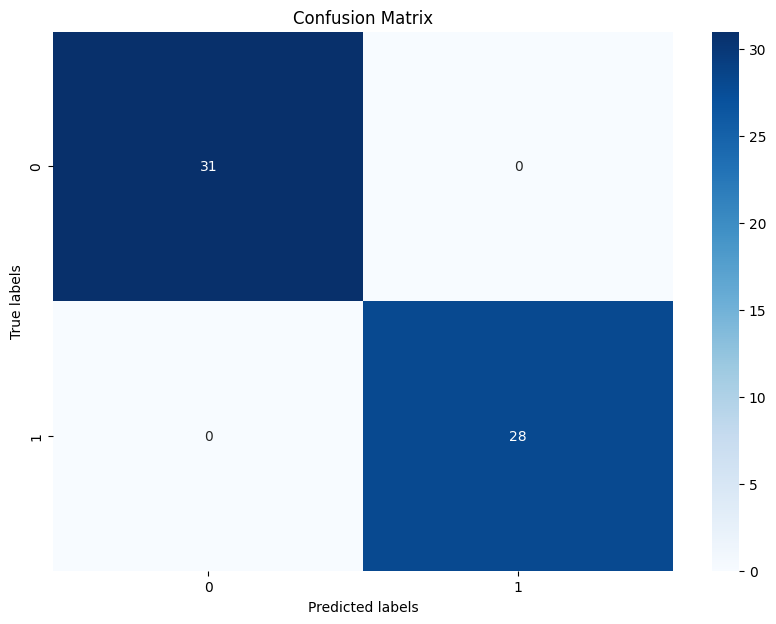

In [106]:
 # confusion matrix
conf_matrix = confusion_matrix(Y_test, final_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Best feature: total_score